### Imports

In [10]:
import pandas as pd 
import matplotlib.pyplot as plt
import torch
%matplotlib inline

### Load & prepare toy dataset

In [11]:
df = pd.read_csv('iris.data' , index_col = None, header = None) 
df.columns = [ 'x1' ,'x2' ,'x3' ,'x4', 'y']
df = df.iloc[50:150]
df['y'] = df['y'].apply(lambda x :0 if x == 'Iris-versicolor' else 1)
df.tail()

,x1,x2,x3,x4,y
145,6.7,3.0,5.2,2.3,1
146,6.3,2.5,5.0,1.9,1
147,6.5,3.0,5.2,2.0,1
148,6.2,3.4,5.4,2.3,1
149,5.9,3.0,5.1,1.8,1


In [12]:
##Assign features and target 

X = torch.tensor(df[['x2' ,'x3']].values , dtype = torch.float)
y = torch.tensor(df['y'].values , dtype = torch.int)


##Shuffling and train/test
torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0) , dtype = torch.long)
X ,y = X[shuffle_idx] , y[shuffle_idx]

percent70 = int(shuffle_idx.size(0) * 0.7)

X_train , X_test = X[shuffle_idx[ : percent70]] , X[shuffle_idx[percent70 : ]]
y_train , y_test = y[shuffle_idx[ : percent70]] ,y[shuffle_idx[percent70 : ]] 

#Normalize 
mu , sigma = X_train.mean(dim = 0) , X_train.std(dim = 0)
X_train = (X_train - mu) /sigma 
X_test = (X_test-mu)/sigma



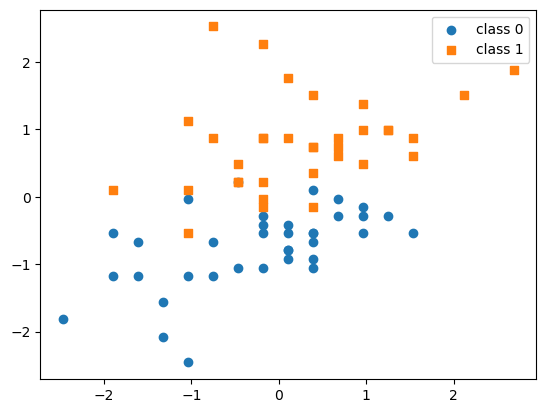

In [13]:
##Making training set plot 
plt.scatter(X_train[y_train ==0 , 0] , X_train[y_train == 0 , 1] , label = 'class 0' , marker = 'o')
plt.scatter(X_train[y_train ==1 , 0] , X_train[y_train == 1 , 1] , label = 'class 1' , marker = 's')
plt.legend()
plt.show()

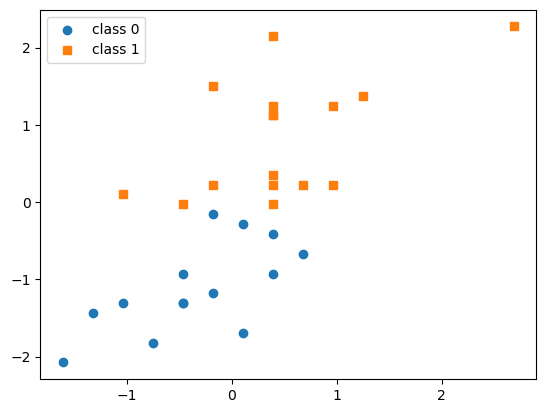

In [14]:
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], label='class 0' , marker = 'o')
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], label='class 1' , marker = 's')
plt.legend()
plt.show()

 ### Implement ADALINE Model 
 

In [26]:
class Adaline1(): #Exactly like linear regression
    
    ##The constructor
    def __init__(self, num_features): 
        self.num_features = num_features 
        self.weights = torch.zeros(num_features , 1 , dtype = torch.float)
        self.bias = torch.zeros( 1, dtype = torch.float)
    
    ##Calculating netinput and activation function 
    def forward( self,x):
        netinputs = torch.add(torch.mm(x, self.weights), self.bias)
        activations = netinputs 
        return activations.view(-1) # convert to row vector 
    
    ##The backward pass
    def backward(self , x, yhat, y): 
        
        grad_loss_yhat = 2*(yhat-y)
        
        grad_yhat_weights = x 
        grad_yhat_bias = 1
        
        #Chain rule : inner times outer
        
        grad_loss_weights = torch.mm(grad_yhat_weights.t() , grad_loss_yhat.view(-1,1)) /y.size(0)
        
        grad_loss_bias = torch.sum(grad_yhat_bias*grad_loss_yhat)/y.size(0)
        
        #return negative gradient 
        return (-1)*grad_loss_weights, (-1)*grad_loss_bias
        
        
        
        

### Defining Training and Evaluation functions 

In [27]:
def loss(yhat,y):
    return torch.mean((yhat -y) **2)

def train(model , x, y, num_epochs , 
         learning_rate = 0.01 , seed = 123 , minibatch_size =10):
    cost =[]
    
    torch.manual_seed(seed)
    for e in range(num_epochs):
        
        ##shuffle epoch 
        shuffle_idx= torch.randperm(y.size(0) , dtype = torch.long)
        minibatches = torch.split(shuffle_idx , minibatch_size)
        
        for minibatch_idx in minibatches: 
            ##Compute outputs :
            yhat = model.forward(x[minibatch_idx])
            
            ##Compute gradients: 
            negative_grad_w , negative_grad_b = model.backward(x[minibatch_idx] , yhat , y[minibatch_idx]) 
            
            ##Update weights: 
            model.weights += learning_rate * negative_grad_w 
            model.bias += learning_rate * negative_grad_b 
            
            ##Logging for each minibatch ### 
            minibatch_loss = loss(yhat, y[minibatch_idx])
            print('Minibatch MSE: %.3f' %minibatch_loss)
        
       ##logiing for each epoch## 
        yhat = model.forward(x)
        curr_loss = loss(yhat ,y)
        print('Epoch %03d' %(e + 1) , end = '')
        print(' |MSE: %.5f' % curr_loss) 
        cost.append(curr_loss)
    
    
    return cost
            
        
            
        

In [28]:
model = Adaline1(num_features=X_train.size(1))
cost = train(model, 
             X_train, y_train.float(),
             num_epochs=20,
             learning_rate=0.1,
             seed=123,
             minibatch_size=10)

Minibatch MSE: 0.500
Minibatch MSE: 0.341
Minibatch MSE: 0.220
Minibatch MSE: 0.245
Minibatch MSE: 0.157
Minibatch MSE: 0.133
Minibatch MSE: 0.144
Epoch 001 |MSE: 0.12142
Minibatch MSE: 0.107
Minibatch MSE: 0.147
Minibatch MSE: 0.064
Minibatch MSE: 0.079
Minibatch MSE: 0.185
Minibatch MSE: 0.063
Minibatch MSE: 0.135
Epoch 002 |MSE: 0.09932
Minibatch MSE: 0.093
Minibatch MSE: 0.064
Minibatch MSE: 0.128
Minibatch MSE: 0.099
Minibatch MSE: 0.079
Minibatch MSE: 0.157
Minibatch MSE: 0.080
Epoch 003 |MSE: 0.09693
Minibatch MSE: 0.131
Minibatch MSE: 0.146
Minibatch MSE: 0.050
Minibatch MSE: 0.095
Minibatch MSE: 0.106
Minibatch MSE: 0.072
Minibatch MSE: 0.102
Epoch 004 |MSE: 0.09658
Minibatch MSE: 0.107
Minibatch MSE: 0.204
Minibatch MSE: 0.149
Minibatch MSE: 0.054
Minibatch MSE: 0.060
Minibatch MSE: 0.056
Minibatch MSE: 0.069
Epoch 005 |MSE: 0.09657
Minibatch MSE: 0.068
Minibatch MSE: 0.111
Minibatch MSE: 0.092
Minibatch MSE: 0.115
Minibatch MSE: 0.157
Minibatch MSE: 0.074
Minibatch MSE: 0.08

 ### Evaluate ADALINE model
 

Plot Loss

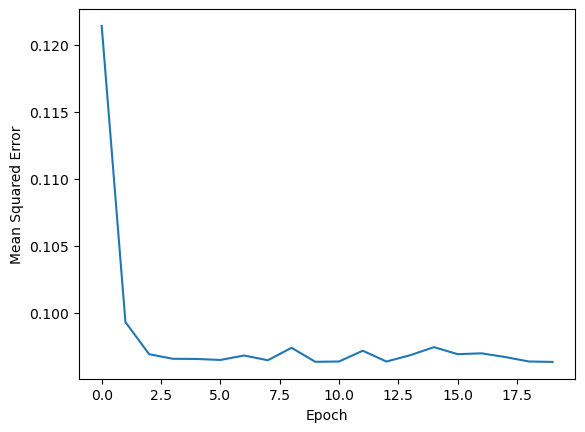

In [30]:
plt.plot(range(len(cost)) , cost)  ##Here cost means MSE 
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.show()


### Compare with analytical solution

In [31]:
print('Weights',model.weights)
print('Bias' , model.bias)

Weights tensor([[-0.0763],
        [ 0.4181]])
Bias tensor([0.4888])


In [40]:
def analytical_solution(x,y):
    Xb = torch.cat( (torch.ones((x.size(0), 1)), x), dim=1)  #create a design matrix 
    w = torch.zeros(x.size(1)) #weight vector 
    z = torch.inverse(torch.matmul(Xb.t() , Xb)) # inverse of X^TX
    params = torch.matmul( z , torch.matmul(Xb.t() , y))  # inverse of X^TX * X^Ty 
    b , w = torch.tensor([params[0]]) , params[1:].view(x.size(1) ,1)
    return w , b 

w , b = analytical_solution(X_train , y_train.float()) #why .float() ? 
print('Analytical weights', w)
print('Analytical bias' , b)



Analytical weights tensor([[-0.0703],
        [ 0.4219]])
Analytical bias tensor([0.4857])


### Evaluate on Evaluation Metric (Prediction Accuracy)

In [45]:
##Training accuracy 
ones = torch.ones(y_train.size()) #make a vector of length(y) which has all entries as 1 
zeros = torch.zeros(y_train.size()) #make a vector of length(y) which has all entries as 0 
train_pred = model.forward(X_train)
train_acc = torch.mean(
(torch.where(train_pred > 0.5 , ones , zeros).int() == y_train).float())

##Testing accuracy 
ones = torch.ones(y_test.size())
zeros = torch.ones(y_test.size())
test_pred = model.forward(X_test)
test_acc = torch.mean(
(torch.where(test_pred > 0.5 , ones, zeros).int() == y_test).float())

print('Training Accuracy : %.2f' %(train_acc * 100))
print('Test Accuracy: %.2f' %(test_acc*100))



Training Accuracy : 90.00
Test Accuracy: 53.33


### Decision Boundary

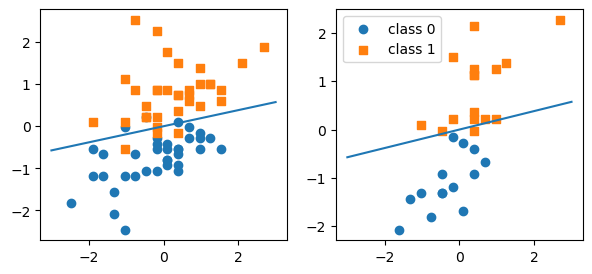

In [51]:
########################
## 2D Decision Boundary
########################
w , b = model.weights , model.bias-0.5  #Why are we subtracting 0.5 ? 
x_min = -3 
y_min = ((-(w[0] * x_min - b[0]))/w[1])

x_max = 3 
y_max = (( -(w[0] *x_max) - b[0]) /w[1])


fig , ax = plt.subplots(1 , 2, sharex = True , figsize = (7,3))

ax[0].plot([x_min , x_max] ,[y_min , y_max])
ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0 , 1] , label = "class 0" , marker = 'o')
ax[0].scatter(X_train[y_train==1,0], X_train[y_train==1,1] , label= 'class 1' , marker = 's')

ax[1].plot([x_min , x_max] ,[y_min,y_max])
ax[1].scatter(X_test[y_test==0,0] , X_test[y_test==0,1] , label = 'class 0' , marker = 'o')
ax[1].scatter(X_test[y_test==1,0] , X_test[y_test==1,1] ,label = 'class 1' , marker = 's') 
ax[1].legend(loc = 'upper left')
plt.show()
